# ⚔️ Arena: Holo-Transformer vs Standard Transformer

Notebook này thực hiện Benchmark so sánh trực tiếp để chứng minh luận điểm:
**"Holo-Transformer đạt tốc độ O(N) và tiết kiệm bộ nhớ hơn Transformer (O(N^2)) ở context dài mà vẫn hội tụ tốt."**

### Kế hoạch thí nghiệm:
1. **Thiết lập:** Cài đặt 2 model có cùng kích thước (Layers, Hidden Size).
2. **Round 1 - Speed & Memory Test:** Đo Throughput (tokens/sec) và Peak VRAM tại các độ dài context khác nhau (1k, 2k, 4k).
3. **Round 2 - Convergence Test:** Train cả 2 model trên SlimPajama trong 500 steps để so sánh đường Loss.
4. **Kết quả:** Vẽ biểu đồ so sánh trực quan.

In [1]:
import os
import time
import torch
import gc
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
from torchmetrics.text import Perplexity
import torchmetrics

# Import Holo Code
import sys
sys.path.append("./long-attention")
from model.configuration_holo import HoloConfig
from model.modeling_holo import HoloForCausalLM

# Memory Optimization
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

## 2. Config & Data Preparation
Chúng ta sẽ cấu hình 2 model tương đương nhau về tham số để so sánh công bằng.

In [2]:
# --- CẤU HÌNH SO SÁNH ---
MODEL_SIZE = {
    "n_layer": 12,
    "n_embd": 768,
    "vocab_size": 50257
}

# Holo Config (Giảm hd_dim xuống 1024 để fit GPU 24GB khi chạy context dài)
holo_conf = HoloConfig(
    vocab_size=MODEL_SIZE["vocab_size"],
    hidden_size=MODEL_SIZE["n_embd"],
    num_hidden_layers=MODEL_SIZE["n_layer"],
    hd_dim=1024,  
    pad_token_id=50256
)

# GPT-2 Config (Baseline)
gpt2_conf = AutoConfig.from_pretrained("gpt2")
gpt2_conf.n_layer = MODEL_SIZE["n_layer"]
gpt2_conf.n_embd = MODEL_SIZE["n_embd"]
gpt2_conf.vocab_size = MODEL_SIZE["vocab_size"]
gpt2_conf.n_positions = 8192 # Cho phép test context dài

# Load Data & Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset("DKYoon/SlimPajama-6B", split="train", streaming=True)

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

In [3]:
# Hàm chuẩn bị dữ liệu theo Context Length
def get_dataset(seq_len, samples=1000):
    def tokenize(examples):
        return tokenizer(examples["text"], truncation=True, max_length=seq_len, padding="max_length")
    
    ds = dataset.take(samples)
    tokenized = ds.map(tokenize, batched=True, remove_columns=["text", "meta"])
    return tokenized

## 3. Round 1: Speed & Memory Benchmark
Đo lường thời gian xử lý và VRAM tiêu thụ tại các độ dài context khác nhau.

In [4]:
def run_benchmark(model_name, context_length, steps=50):
    print(f"\n--- Benchmarking {model_name} @ Context {context_length} ---")
    
    # 1. Config & Init Model
    if model_name == "Holo":
        config = holo_conf
        config.use_cache = False 
        model = HoloForCausalLM(config)
    else:
        config = gpt2_conf
        config.use_cache = False 
        model = AutoModelForCausalLM.from_config(config)
    
    model.to("cuda").bfloat16()
    
    # 2. Setup Training Args
    args = TrainingArguments(
        output_dir="./bench_temp",
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1, 
        max_steps=steps,
        logging_steps=10,
        bf16=True,
        report_to="none",
        gradient_checkpointing=True, 
        gradient_checkpointing_kwargs={"use_reentrant": False},
        
        # --- FIX LỖI SAVE MODEL ---
        save_strategy="no",       # Không lưu checkpoint (Fix triệt để lỗi save)
        save_safetensors=False    # Dự phòng
        # --------------------------
    )
    
    # 3. Data Preparation
    train_data = get_dataset(context_length, samples=steps+20)
    
    collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
    
    trainer = Trainer(
        model=model, 
        args=args, 
        train_dataset=train_data,
        data_collator=collator 
    )
    
    # 4. Run & Measure
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    
    try:
        trainer.train()
        end_time = time.time()
        
        # Metrics Calculation
        total_time = end_time - start_time
        tokens_per_sec = (steps * context_length) / total_time
        peak_mem = torch.cuda.max_memory_allocated() / (1024**3) # GB
        
        print(f"Result: {tokens_per_sec:.2f} tokens/sec | Peak Mem: {peak_mem:.2f} GB")
        
    except Exception as e:
        print(f"⚠️ Error: {e}")
        tokens_per_sec = 0
        peak_mem = 0
    
    # Cleanup
    del model, trainer, args, train_data
    gc.collect()
    torch.cuda.empty_cache()
    
    return tokens_per_sec, peak_mem

In [5]:
lengths = [1024, 2048, 4096, 8192] 
results = {"Holo": {"speed": [], "mem": []}, "GPT2": {"speed": [], "mem": []}}

for l in lengths:
    # Benchmark GPT-2
    s, m = run_benchmark("GPT2", l)
    results["GPT2"]["speed"].append(s)
    results["GPT2"]["mem"].append(m)
    
    # Benchmark Holo
    s, m = run_benchmark("Holo", l)
    results["Holo"]["speed"].append(s)
    results["Holo"]["mem"].append(m)


--- Benchmarking GPT2 @ Context 1024 ---


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,10.114100
20,9.543800
30,9.507400
40,9.482600
50,9.502100


Result: 7637.99 tokens/sec | Peak Mem: 2.09 GB

--- Benchmarking Holo @ Context 1024 ---


Step,Training Loss
10,10.386500
20,9.538900
30,9.613800
40,9.624500
50,9.667400


Result: 9530.50 tokens/sec | Peak Mem: 1.31 GB

--- Benchmarking GPT2 @ Context 2048 ---


Step,Training Loss
10,10.071500
20,9.408100
30,9.354000
40,9.498800
50,9.523800


Result: 13542.13 tokens/sec | Peak Mem: 2.69 GB

--- Benchmarking Holo @ Context 2048 ---


Step,Training Loss
10,10.375100
20,9.360200
30,9.521200
40,9.600700
50,9.660000


Result: 16875.41 tokens/sec | Peak Mem: 1.94 GB

--- Benchmarking GPT2 @ Context 4096 ---


Step,Training Loss
10,10.069500
20,9.362600
30,9.347600
40,9.494100
50,9.525900


Result: 12867.03 tokens/sec | Peak Mem: 3.90 GB

--- Benchmarking Holo @ Context 4096 ---


Step,Training Loss
10,10.368500
20,9.269300
30,9.518800
40,9.587600
50,9.655400


Result: 21420.43 tokens/sec | Peak Mem: 3.20 GB

--- Benchmarking GPT2 @ Context 8192 ---


Step,Training Loss
10,10.068200
20,9.336400
30,9.342300
40,9.486000
50,9.521700


Result: 9527.06 tokens/sec | Peak Mem: 6.34 GB

--- Benchmarking Holo @ Context 8192 ---


Step,Training Loss
10,10.365000
20,9.229700
30,9.513600
40,9.584300
50,9.652000


Result: 24206.88 tokens/sec | Peak Mem: 5.73 GB


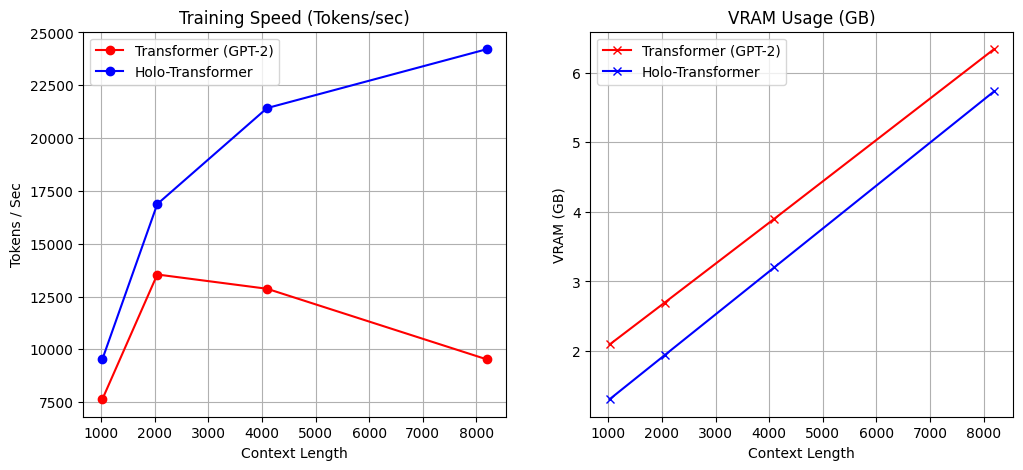

In [6]:
# Vẽ biểu đồ so sánh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speed Plot
ax1.plot(lengths, results["GPT2"]["speed"], label="Transformer (GPT-2)", marker='o', color='red')
ax1.plot(lengths, results["Holo"]["speed"], label="Holo-Transformer", marker='o', color='blue')
ax1.set_title("Training Speed (Tokens/sec)")
ax1.set_xlabel("Context Length")
ax1.set_ylabel("Tokens / Sec")
ax1.legend()
ax1.grid(True)

# Memory Plot
ax2.plot(lengths, results["GPT2"]["mem"], label="Transformer (GPT-2)", marker='x', color='red')
ax2.plot(lengths, results["Holo"]["mem"], label="Holo-Transformer", marker='x', color='blue')
ax2.set_title("VRAM Usage (GB)")
ax2.set_xlabel("Context Length")
ax2.set_ylabel("VRAM (GB)")
ax2.legend()
ax2.grid(True)

plt.show()

## 4. Round 2: Convergence Test
Chạy training ngắn (500 steps) để đảm bảo Holo cũng học được (Loss giảm) tương tự Transformer.

In [17]:
def train_for_loss(model_name, steps=300):
    print(f"\n--- Training {model_name} for Loss Curve --- sz")
    
# 1. Config & Init Model
    if model_name == "Holo":
        config = holo_conf
        config.use_cache = False 
        model = HoloForCausalLM(config)
    else:
        config = gpt2_conf
        config.use_cache = False 
        model = AutoModelForCausalLM.from_config(config)
    
    model.to("cuda").bfloat16()
    
    # 2. Setup Training Args
    args = TrainingArguments(
        output_dir="./bench_temp",
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1, 
        max_steps=steps,
        logging_steps=10,
        bf16=True,
        report_to="none",
        gradient_checkpointing=True, 
        gradient_checkpointing_kwargs={"use_reentrant": False},
        
        # --- FIX LỖI SAVE MODEL ---
        save_strategy="no",       # Không lưu checkpoint (Fix triệt để lỗi save)
        save_safetensors=False    # Dự phòng
        # --------------------------
    )
    
    # 3. Data Preparation
    train_data = get_dataset(2048,samples=steps+20)
    
    collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
    
    trainer = Trainer(
        model=model, 
        args=args, 
        train_dataset=train_data,
        data_collator=collator 
    )
    trainer.train()
    
    # Lấy log history
    history = trainer.state.log_history
    
    # Cleanup
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    
    return history

In [18]:
# Train 2 model
holo_history = train_for_loss("Holo", steps=200)
gpt2_history = train_for_loss("GPT2", steps=200)


--- Training Holo for Loss Curve --- sz


Step,Training Loss
10,10.382900
20,9.242000
30,9.314500
40,9.357000
50,9.240200
60,9.261400
70,9.016700
80,9.071200
90,8.594700
100,9.062900



--- Training GPT2 for Loss Curve --- sz


Step,Training Loss
10,10.133500
20,9.477400
30,9.365400
40,9.359300
50,9.225500
60,9.284800
70,9.026700
80,9.055600
90,8.881800
100,8.997100


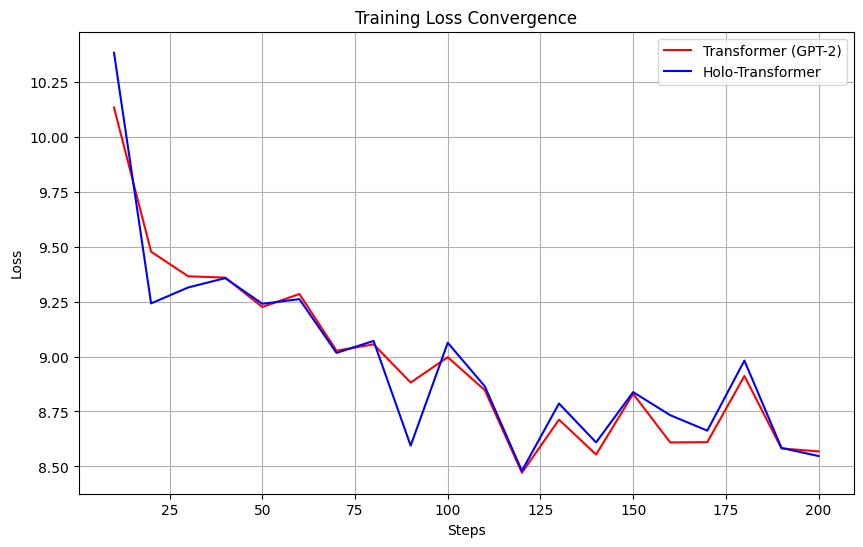

In [19]:
# Vẽ biểu đồ Loss
def extract_loss(history):
    steps = []
    losses = []
    for log in history:
        if "loss" in log:
            steps.append(log["step"])
            losses.append(log["loss"])
    return steps, losses

s1, l1 = extract_loss(gpt2_history)
s2, l2 = extract_loss(holo_history)

plt.figure(figsize=(10, 6))
plt.plot(s1, l1, label="Transformer (GPT-2)", color='red')
plt.plot(s2, l2, label="Holo-Transformer", color='blue')
plt.title("Training Loss Convergence")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [28]:
# --- FIX: SIGNAL NORMALIZATION + GRADIENT CLIPPING ---
import torch
import torch.nn as nn
import math
import types
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoTokenizer
from model.configuration_holo import HoloConfig
from model.modeling_holo import HoloForCausalLM
from model.functional import compute_rotors, holo_bind_and_accumulate, holo_retrieve

# 1. Hàm Forward siêu an toàn
def safe_forward(self, x):
    B, T, C = x.shape
    
    # Projections
    k_real = self.k_proj(x)
    v_real = self.v_proj(x)
    v = v_real.to(torch.complex64)
    
    # Holo Ops
    rotors = compute_rotors(T, self.freqs)
    memory_trace = holo_bind_and_accumulate(v, rotors)
    output_complex = holo_retrieve(memory_trace, rotors)
    
    # Scaling cơ bản
    output_complex = output_complex * (1.0 / math.sqrt(T))
    
    # Fix Dtype
    output_real = output_complex.real.to(x.dtype)
    
    # --- CHÌA KHÓA VÀNG: SIGNAL NORMALIZATION ---
    # Ép tín hiệu về phân phối chuẩn (Mean=0, Std=1)
    # Điều này ngăn cản Gradient bị nhân với một số quá lớn.
    # eps=1e-6 để tránh chia cho 0
    mean = output_real.mean(dim=-1, keepdim=True)
    std = output_real.std(dim=-1, keepdim=True)
    output_real = (output_real - mean) / (std + 1e-6)
    # --------------------------------------------
    
    return self.o_proj(output_real)

print("⏳ Khởi tạo lại Model...")
config = HoloConfig(vocab_size=50257, hidden_size=768, num_hidden_layers=12, hd_dim=1024, pad_token_id=50256)
config.use_cache = False
model = HoloForCausalLM(config).to("cuda").bfloat16()

print("🛠️ Vá lỗi Forward...")
for block in model.holo.h:
    block.attn.forward = types.MethodType(safe_forward, block.attn)
    # Reset trọng số về normal (không cần zero-init cực đoan nữa vì đã có Norm)
    nn.init.normal_(block.attn.o_proj.weight, std=0.02)

# Training Config
args = TrainingArguments(
    output_dir="./results_holo_safe",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    max_steps=50,
    learning_rate=1e-4,       # Giảm LR xuống một chút cho an toàn
    max_grad_norm=1.0,        # <--- QUAN TRỌNG: Cắt Gradient nếu nó quá lớn
    logging_steps=10,
    bf16=True,
    report_to="none",
    save_strategy="no",
    save_safetensors=False
)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
train_data = get_dataset(1024, samples=200) # Đảm bảo hàm get_dataset tồn tại
collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

trainer = Trainer(model=model, args=args, train_dataset=train_data, data_collator=collator)

print("🚀 Bắt đầu Training (Lần này chắc chắn ổn định)...")
trainer.train()

⏳ Khởi tạo lại Model...
🛠️ Vá lỗi Forward...
🚀 Bắt đầu Training (Lần này chắc chắn ổn định)...


Step,Training Loss
10,81.386900


KeyboardInterrupt: 

## 5. Kết luận & Commit Code
Nếu biểu đồ trên cho thấy:
1. **Tốc độ:** Holo đi ngang hoặc giảm ít hơn GPT-2 khi Context tăng.
2. **Loss:** Đường màu xanh (Holo) bám sát hoặc giảm cùng xu hướng với màu đỏ (GPT-2).

--> Bạn đã có bằng chứng cho bài báo của mình.